In [1]:
import os
import pywt
import glob
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-06-20 17:18:48.733438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 17:18:51.935652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data and preprocess

In [2]:
xTrain = np.load("./xTrain.npy")
yTrain = np.load("./yTrain.npy", allow_pickle=True)

xTest = np.load("./xTest.npy")
yTest = np.load("./yTest.npy", allow_pickle=True)

In [3]:
# Columns are:
#
# 0 = 'Beta_p'
# 1 = 'Va'
# 2 = 'Tratio'
# 3 = 'entropy'
# 4 = 'crossHelicity'
# 5 = 'residualEnergy'
# 6 = 'TotalPressure'
# 7 = 'bFluctuations'

In [4]:
nClasses = len( np. unique( yTrain ) )
nClasses

5

In [5]:
y = tf.one_hot(yTrain,nClasses)

2024-06-20 17:19:14.954192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5


### Neural Network

In [6]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [7]:
def create_probablistic_bnn_model(rows,columns):
    
    inputs = tf.keras.layers.Input(shape=columns)
    
    hidden1 = tf.keras.layers.Dense(16, activation='relu')(inputs)    
    hidden2 = tf.keras.layers.Dense(8, activation='relu')(hidden1)
    
    distribution_params = layers.Dense(nClasses)(hidden2)
    outputs = tfp.layers.OneHotCategorical(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [8]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [10]:
bnn = create_probablistic_bnn_model(xTrain.shape[0],xTrain.shape[1])
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
 one_hot_categorical (OneHot  ((None, 5),              0         
 Categorical)                 (None, 5))                         
                                                                 
Total params: 309
Trainable params: 309
Non-trainable params: 0
_______________________________________________________________

In [10]:
bnn.compile( loss=negative_loglikelihood, metrics=['accuracy'] )

In [11]:
history = bnn.fit( xTrain, y, epochs=200, verbose=1, 
                  use_multiprocessing=True, validation_split=0.2)

Epoch 1/200


2024-02-22 17:16:49.097610: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4710012af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 17:16:49.097661: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN Black, Compute Capability 3.5
2024-02-22 17:16:49.103455: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-22 17:16:50.000012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-02-22 17:16:50.206109: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-22 17:16:50.507838: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1225/1225 [==============================] - 73s 51ms/step - loss: 1.4880 - accuracy: 0.2380 - val_loss: 1.3788 - val_accuracy: 0.2724
Epoch 2/200
1225/1225 [==============================] - 63s 52ms/step - loss: 1.2326 - accuracy: 0.3186 - val_loss: 1.1018 - val_accuracy: 0.3761
Epoch 3/200
1225/1225 [==============================] - 62s 51ms/step - loss: 1.0035 - accuracy: 0.4235 - val_loss: 0.9199 - val_accuracy: 0.4673
Epoch 4/200
1225/1225 [==============================] - 61s 50ms/step - loss: 0.8525 - accuracy: 0.5017 - val_loss: 0.8040 - val_accuracy: 0.5385
Epoch 5/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.7649 - accuracy: 0.5571 - val_loss: 0.7356 - val_accuracy: 0.5764
Epoch 6/200
1225/1225 [==============================] - 63s 52ms/step - loss: 0.7092 - accuracy: 0.5943 - val_loss: 0.6901 - val_accuracy: 0.6008
Epoch 7/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.6723 - accuracy: 0.6156 - val_loss: 0.6569 - val_

1225/1225 [==============================] - 62s 51ms/step - loss: 0.4169 - accuracy: 0.7730 - val_loss: 0.4085 - val_accuracy: 0.7787
Epoch 112/200
1225/1225 [==============================] - 63s 51ms/step - loss: 0.4169 - accuracy: 0.7738 - val_loss: 0.4040 - val_accuracy: 0.7814
Epoch 113/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.4164 - accuracy: 0.7740 - val_loss: 0.4035 - val_accuracy: 0.7778
Epoch 114/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.4166 - accuracy: 0.7746 - val_loss: 0.4335 - val_accuracy: 0.7680
Epoch 115/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.4163 - accuracy: 0.7753 - val_loss: 0.4046 - val_accuracy: 0.7754
Epoch 116/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.4153 - accuracy: 0.7742 - val_loss: 0.4100 - val_accuracy: 0.7692
Epoch 117/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.4161 - accuracy: 0.7726 - val_loss: 0

1225/1225 [==============================] - 63s 51ms/step - loss: 0.4068 - accuracy: 0.7823 - val_loss: 0.3955 - val_accuracy: 0.7784
Epoch 167/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.4053 - accuracy: 0.7771 - val_loss: 0.4026 - val_accuracy: 0.7757
Epoch 168/200
1225/1225 [==============================] - 64s 52ms/step - loss: 0.4055 - accuracy: 0.7788 - val_loss: 0.4109 - val_accuracy: 0.7847
Epoch 169/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.4057 - accuracy: 0.7815 - val_loss: 0.4003 - val_accuracy: 0.7795
Epoch 170/200
1225/1225 [==============================] - 63s 51ms/step - loss: 0.4062 - accuracy: 0.7774 - val_loss: 0.3966 - val_accuracy: 0.7894
Epoch 171/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.4058 - accuracy: 0.7813 - val_loss: 0.3979 - val_accuracy: 0.7811
Epoch 172/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.4058 - accuracy: 0.7814 - val_loss: 0

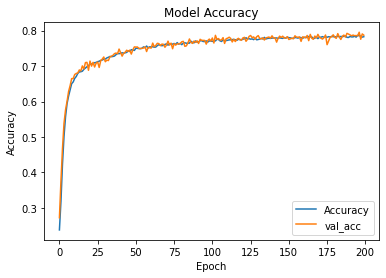

In [12]:
plt.plot( history.history['accuracy'], label="Accuracy")
plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

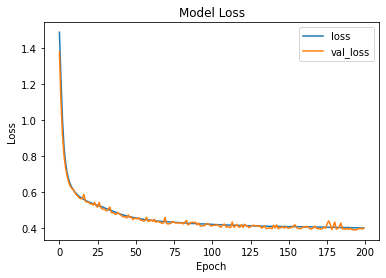

In [13]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [14]:
# serialize weights to HDF5
bnn.save_weights("./model_weights_8PNN_with_sheath.h5")

In [16]:
from scipy.stats import entropy

preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )

In [19]:
font = {'weight' : 'bold', 'size'   : 24}
plt.rc('font', **font)

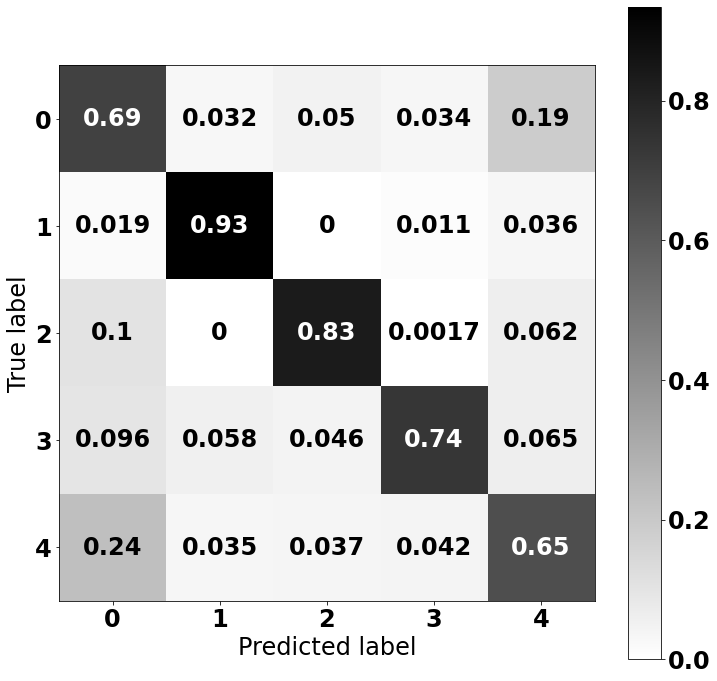

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))

cm = confusion_matrix( yTest.astype(int), preds, normalize='true' )
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax, cmap='gist_yarg')

In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

yTest = yTest.astype(int)

print( "Macro F1:", np.round( f1_score(yTest, preds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(yTest, preds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(yTest, preds, average='macro'), 4 ))
print( "Accuracy:", np.round( accuracy_score(yTest, preds), 4 ))

Macro F1: 0.771
Macro Precision: 0.7775
Macro Recall: 0.769
Accuracy: 0.7694


### If model already trained - Load the saved model for analysis

In [9]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

bnn = create_probablistic_bnn_model( xTest.shape[0], xTest.shape[1] )
 
# load weights into new model
bnn.load_weights("./model_weights_8PNN_with_sheath.h5")

In [10]:
from scipy.stats import entropy

preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )

Text(0.5, 1.0, 'Distribution of Prediction Uncertenties')

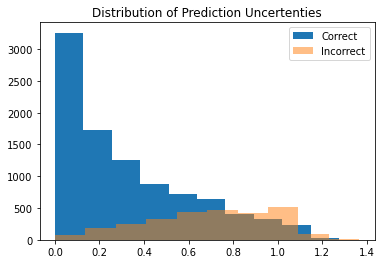

In [17]:
en = np.array( en )
preds = np.array( preds )

c = np.where( preds == yTest.astype('int') )
w = np.where( preds != yTest )
plt.hist( en[c], label='Correct')
plt.hist( en[w], label='Incorrect', alpha=0.5)
plt.legend()
plt.title('Distribution of Prediction Uncertenties')

In [13]:
from sklearn.metrics import accuracy_score

np.round( accuracy_score(yTest.astype(int), preds), 4 ) 

0.7677

In [38]:
font = { 'weight' : 'bold', 'size'   : 12}
plt.rc('font', **font)

In [41]:
y = yTest.astype(int)
preds = np.array(preds)

n = len(preds)
ens = np.arange(0.1,1.1,0.1)

acs = []
per = []
for e in ens:
    ix = np.where( en <= e )
    per.append( (len(ix[0])/n)*100 )
    acs.append( np.round( accuracy_score(y[ix], preds[ix]), 4 )*100 ) 

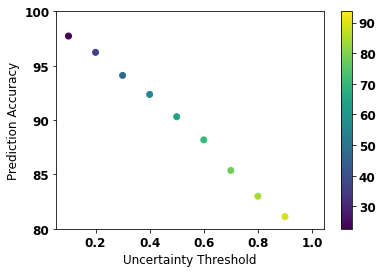

In [45]:
plt.scatter( ens, acs, c=per )

plt.ylim(80,100)
plt.yticks([80,85,90,95,100])
plt.xlabel('Uncertainty Threshold')
plt.ylabel('Prediction Accuracy')
plt.colorbar()